In [2]:
%matplotlib inline

import pdb
import numpy as np
import graphviz
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from scipy.io import loadmat
from mapFeature import mapFeature
from sigmoid import sigmoid
from costFunctionLogisticRegression import costFunctionLogisticRegression
from gradientLogisticRegression import gradientLogisticRegression

## Decision tree

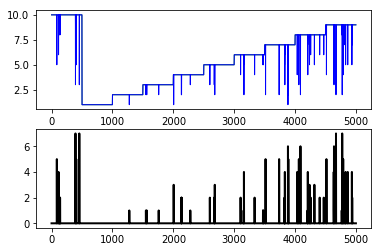

MSE for decision tree: 0.15 
 


In [54]:
# load Training Data Andrew Ng Machine Learning MOOC
data = loadmat('ex3data1.mat')
X = data['X']
y = data['y']

n = X.shape[0]
num_labels = np.unique(y).size

# classification tree
clf = tree.DecisionTreeClassifier(min_samples_split=3)
clf = clf.fit(X, y)

# tree_data = tree.export_graphviz(clf, out_file=None, filled=True, rounded=True) 
# graph = graphviz.Source(tree_data)
# graph

pred = clf.predict(X).reshape((-1,1))

# plot results
plt.subplot(211)
plt.plot(y,'g', linewidth=1)
plt.plot(pred,'b', linewidth=1)
plt.subplot(212)
plt.plot(y - pred, 'k', linewidth=2);
plt.show()

# calculate mean square error
mse = (1 / len(y)) * np.sum((y - pred)**2)
print('MSE for decision tree: %.2f \n ' % mse)

## Bagged tree

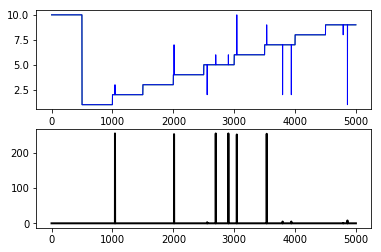

MSE for bagging tree: 0.03 
 


In [55]:
# load Training Data Andrew Ng Machine Learning MOOC
data = loadmat('ex3data1.mat')
X = data['X']
y = data['y']

n = X.shape[0]
num_labels = np.unique(y).size

# classification tree
d_tree = tree.DecisionTreeClassifier(min_samples_split=3)
clf = BaggingClassifier(d_tree)
clf = clf.fit(X, y.flatten())
pred = clf.predict(X).reshape((-1,1))

# plot results
plt.subplot(211)
plt.plot(y,'g', linewidth=1)
plt.plot(pred,'b', linewidth=1)
plt.subplot(212)
plt.plot(y - pred, 'k', linewidth=2);
plt.show()

# calculate mean square error
mse = (1 / len(y)) * np.sum((y - pred)**2)
print('MSE for bagging tree: %.2f \n ' % mse)

## Classification with cross validation

In [61]:
# load the data
data = loadmat('ex3data1.mat')
X = data['X']
y = data['y']

n = X.shape[0]
num_labels = np.unique(y).size

# add bias to X
bias = np.ones((n,1))
Xdata = np.hstack((bias,X))

# holding out 20% of the data for testing 
num_folds = 5
lam = 0.1

# classification method to use
method = 'DecisionTree'

# seed random number generator
np.random.seed(2000)

kf = KFold(n_splits=num_folds, shuffle=True)
predictions = np.zeros((y.size))

for train_index, test_index in kf.split(Xdata):
    trainCV, testCV = Xdata[train_index], Xdata[test_index]
    trainGT, testGT = y[train_index], y[test_index]
    
    if method == 'LogisticRegression':
        # initialize theta to store all theta for each label
        all_theta = np.zeros((num_labels,Xdata.shape[1]))
        for c in range(1, num_labels+1):
            initial_theta = np.zeros((Xdata.shape[1],1))
            #pdb.set_trace()
            labeledGT = ((trainGT == c) * 1).reshape((-1,1))
            grad = gradientLogisticRegression(initial_theta, Xdata, y, lam)

            # optimize theta
            theta = fmin_bfgs(costFunctionLogisticRegression, grad, args=(trainCV, labeledGT, lam), \
                      fprime=gradientLogisticRegression, disp=False)

            all_theta[c-1,:] = theta
        #end
        h = sigmoid(np.dot(testCV, all_theta.T))
        h[h >= threshold] = 1
        h[h < threshold] = 0
    elif method == 'KNN':
        knn = KNeighborsClassifier(n_neighbors=3, algorithm='auto')
        knn.fit(trainCV, trainGT.flatten())
        h = knn.predict(testCV)
    elif method == 'DecisionTree':
        clf = tree.DecisionTreeClassifier(min_samples_split=3)
        clf = clf.fit(trainCV, trainGT)
        h = clf.predict(testCV)
    elif method == 'BaggedTree':
        d_tree = tree.DecisionTreeClassifier(min_samples_split=3)
        clf = BaggingClassifier(d_tree)
        clf = clf.fit(trainCV, trainGT.flatten())
        pred = clf.predict(testCV)
    else:
        print('Unknown classification method')
    # end
    
    # gather predictions from each run
    predictions[test_index] = h
# end

# generate confusion matrix
confusion_mat = confusion_matrix(y, predictions)
print('confusion matrix: \n', confusion_mat, '\n')

# calculate accuracy from confusion matrix
accuracy1 = np.sum( np.diag(confusion_mat) ) / np.sum(confusion_mat)
print('%s: Lambda = %d, accuracy using confusion matrix = %.2f%% \n' % (method,lam,accuracy1*100))

# calculate accuracy from accuracy_score
accuracy2 = accuracy_score(y, predictions)
print('%s: Lambda = %d, accuracy using scikit learn = %.2f%% \n' % (method,lam,accuracy2*100))

confusion matrix: 
 [[440   9   9   5   8   6   5  15   2   1]
 [ 12 353  34  20   8  10  25  21   8   9]
 [  8  31 362  11  27   2  18  24  14   3]
 [  9  10   5 402  11  17   7  10  25   4]
 [ 12  11  43  15 348  14  10  20  19   8]
 [  2  15   3  23  27 407   5  12   1   5]
 [  7  15   8  12  11   4 403  10  24   6]
 [ 12  31  29  15  27  14   7 346  16   3]
 [  6   8  15  24  20   3  18  14 388   4]
 [  0  12   2   2  11   4   4  12   4 449]] 

DecisionTree: Lambda = 0, accuracy using confusion matrix = 77.96% 

DecisionTree: Lambda = 0, accuracy using scikit learn = 77.96% 



## Adaboost

In [8]:
data = np.loadtxt('bupa.csv', delimiter=',')